# **sales_predictions**

Olen Sluder

*A portfolio project demonstrating sales predictions for items sold at various retail outlets. The goal is to help the retailer understand the properties of items and outlets that play crucial roles in increasing sales.*

## Parts 1 & 2

**Part 1 Objective**: Create the project repository.

- Create a GitHub Account
- Set up a GitHub repository that will house your first portfolio project.
- Add Markdown cells with your name and section headers to the notebook.
- Add the Google Colab Notebook to your GitHub repository.

**Part 2 Objective**: Practice using pandas to clean and explore data.

For Part 2, your task is to use pandas to load in the data and start exploring and cleaning it. As data scientists, about [80% of our time is spent on data preparation](https://www.forbes.com/sites/gilpress/2016/03/23/data-preparation-most-time-consuming-least-enjoyable-data-science-task-survey-says/?sh=478ec4796f63) - so this is a very important step!

- Download the data using this link: [download the data](https://drive.google.com/file/d/1syH81TVrbBsdymLT_jl2JIf6IjPXtSQw/view?usp=sharing). (Note: [Original data source](https://datahack.analyticsvidhya.com/contest/practice-problem-big-mart-sales-iii/).)
- Insert code below the heading "Load Data"
    - Use Pandas to read the sales prediction data set into Google Colab.
    - Use `df.info()` and `df.head()` methods to preview the first rows of your data and a summary of your DataFrame's columns.
- Insert code below the heading "Clean Data"
    - Explore the data - what do you need to do to clean this data? Clean it!
    - Be sure to address each of the following tasks:
        1. How many rows and columns?
        1. What are the datatypes of each variable?
        1. Are there duplicates? If so, drop any duplicates.
        1. Identify missing values.
        1. Decide on how to address the missing values and do it! (This requires your judgement, so explain your choice).
        1. Confirm that there are no missing values after addressing them.
        1. Find and fix any inconsistent categories of data (example: fix cat, Cat, and cats so that they are consistent).
        1. For any numerical columns, obtain the summary statistics of each (min, max, mean).
- Here are a few resources to help you consider more advanced ways to deal with missing values in your dataset:
    - [Missing Data, its types, and statistical methods to deal with it](https://blog.usejournal.com/missing-data-its-types-and-statistical-methods-to-deal-with-it-5cf8b71a443f).
    - [6 Different Ways to Compensate for Missing Values In a Dataset](https://towardsdatascience.com/6-different-ways-to-compensate-for-missing-values-data-imputation-with-examples-6022d9ca0779).
    - [Dealing with missing data: Key assumptions and methods for applied analysis](http://www.bu.edu/sph/files/2014/05/Marina-tech-report.pdf).

### Data Dictionary

| Column Name | Type | Description |
|-|-|-|
| Item_Identifier | String | Unique product ID |
| Item_Weight | Float | Weight of product |
| Item_Fat_Content | String | Whether the product is low fat or regular |
| Item_Visibility | Float | The percentage of total display area of all products in a store allocated to the particular product |
| Item_Type | String | The category to which the product belongs |
| Item_MRP | Float | Maximum Retail Price (list price) of the product
| Outlet_Identifier | String | Unique store ID |
| Outlet_Establishment_Year | Integer | The year in which store was established |
| Outlet_Size | String | The size of the store in terms of ground area covered |
| Outlet_Location_Type | String | The type of area in which the store is located |
| Outlet_Type | String | Whether the outlet is a grocery store or some sort of supermarket |
| Item_Outlet_Sales | Float | Sales of the product in the particular store |

### Helper Code

> Programs must be written for people to read, and only incidentally for machines to execute. ―Harold Abelson and Gerald Jay Sussman, *Structure and Interpretation of Computer Programs* (1984)

In [311]:
import matplotlib as mpl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter


# Check the current version of packages in Colab
print('Package Versions:')
print(f'\tMatplotlib = {mpl.__version__}')
print(f'\tNumpy = {np.__version__}')
print(f'\tPandas = {pd.__version__}')
print(f'\tSeaborn = {sns.__version__}')


def change_data_type(series, 
                     new_type):
  """
  Change a pandas Series' data type.

  Args:
    series (pandas.core.Series): The Series having its data type changed.
    new_type (type): The data type to change the Series to.
    
  Returns:
    pandas.core.Series: The new Series else the original column.
  """
  try:
    new_series = series.astype(new_type)
  except ValueError as ex:
    new_series = series
    display(ex)

  return new_series


def display_duplicate_count(data):
  """
  Display a pandas DataFrame's duplicate count.

  Args:
    data (pandas.core.DataFrame): The DataFrame being checked for duplicates.
  """
  try:
    count = data.duplicated().sum()
    print(f'There are {count} duplicates.')
  except AttributeError as ex:
    display(ex)

  return


def display_missing_data(data):
  """
  Display a pandas DataFrame's column(s) with missing data.

  Args:
    data (pandas.core.DataFrame): The DataFrame being checked for missing data.
  """
  try:
    missing_data = data.isna().sum()
    missing_data = missing_data[missing_data > 0]
    if len(missing_data) == 0:
      print('There is no missing data.')
    else:
      print(missing_data)
  except AttributeError as ex:
    display(ex)
 
  return


def barplot(data,
            x,
            figsize=(10, 5),
            tight_layout=True,
            title='',
            xlabel='',
            xtick_labels=[],
            xtick_rotation=0):
  """
  Plot bar plot for specified column.

  Args:
    data (pandas.core.DataFrame): The DataFrame being plotted.
    x (str): The name of the column to plot on the x-axis.
    figsize (tuple): The size of the plot's figure.
    tight_layout (bool): Create a tight plot layout?
    title (str): The title of the plot.
    xlabel (str): The x-axis label.
    xtick_labels (list): The x-tick labels.
    xtick_rotation (int): The degrees to rotate the x-tick labels.

  Returns:
    matplotlib.axes._subplots.AxesSubplot: The subplot.
  """
  plt.figure(figsize=figsize)

  ax = sns.countplot(data=data, x=x)

  ax.set_title(title)

  if len(xlabel) > 0:
    ax.set_xlabel(xlabel)

  plt.xticks(rotation=xtick_rotation)

  if len(xtick_labels) > 0:
    ax.set_xticklabels(xtick_labels)

  if tight_layout:
    plt.tight_layout()

  return ax


def whaleyplot(data,
               x,
               figsize=(10, 5),
               meanprops={'color': 'red', 'linestyle': '--'},
               medianprops={'color': 'black', 'linestyle': '--'},
               notch=False,
               tight_layout=True,
               title='',
               xlabel=''):
  """
  Plot histogram and boxplot on same x-axis for specified column.
 
  Args:
    data (pandas.core.DataFrame): The DataFrame being plotted.
    x (str): The name of the column to plot on the x-axis.
    figsize (tuple): The size of the plot's figure.
    meanprops (Dict): Properties of the mean line.
    medianprops (Dict): Properties of the mean line.
    notch (bool): Should the box be notched?
    tight_layout (bool): Create a tight plot layout?
    title (str): The title of the plot.
    xlabel (str): The x-axis label.

  Returns:
    matplotlib.figure.Figure: The subplot figure.
    numpy.ndarray: The subplot axes.

 TODO:
    Implement meanprops and medianprops.
  """
  # Derived from S. Whaley/Coding Dojo, Exemplar DS Project 1
  fig, (histplot, boxplot) = plt.subplots(nrows=2, figsize=figsize, sharex=True)

  sns.histplot(ax=histplot, data=data, x=x, kde=True, legend=True)
  sns.boxplot(ax=boxplot, data=data, x=x, medianprops={}, notch=notch)

  mean_value = data[x].mean()
  histplot.axvline(mean_value,
                   color='red', 
                   linestyle='-', 
                   label=f'Mean = {mean_value:,.2f}')
  boxplot.axvline(mean_value,
                  color='red', 
                  linestyle='-')
  
  median_value = data[x].median()
  histplot.axvline(median_value,
                   color='black', 
                   linestyle='-', 
                   label=f'Median = {median_value:,.2f}')
  boxplot.axvline(median_value,
                  color='black', 
                  linestyle='-')
  
  histplot.legend(loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
  histplot.set_title(title)

  if len(xlabel) > 0:
    boxplot.set_xlabel(xlabel)
  else:
    boxplot.set_xlabel(x)

  if tight_layout:
    plt.tight_layout()

  return fig, (histplot, boxplot)
 
# Luke Codewalker returns!!

Package Versions:
	Matplotlib = 3.5.3
	Numpy = 1.22.4
	Pandas = 1.3.5
	Seaborn = 0.11.2


### Load Data

In [312]:
dataset = 'sales_predictions.csv'
df = pd.read_csv(dataset)

### Clean Data

#### Dataset Shape

Check the DataFrame's info:

In [313]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


- There are 8,523 rows and 12 columns.

#### Duplicates

Check for duplicates:

In [314]:
display_duplicate_count(df)

There are 0 duplicates.


#### Missing Data

Check for missing data:

In [315]:
display_missing_data(df)

Item_Weight    1463
Outlet_Size    2410
dtype: int64


We will fill missing weights from other rows of the same item identifier:

In [316]:
# Create filter of items missing weights and create lookup dataframe of item weights
items_missing_weights = df[df['Item_Weight'].isna()]['Item_Identifier']
filter = df['Item_Identifier'].isin(items_missing_weights)
missing_item_weights = df[filter][['Item_Identifier', 'Item_Weight']]
missing_item_weights = missing_item_weights.dropna()
missing_item_weights = missing_item_weights.drop_duplicates()

# Fill missing weights from lookup dataframe
for item in missing_item_weights['Item_Identifier']:
  filter = missing_item_weights['Item_Identifier'] == item
  weight = missing_item_weights[filter]['Item_Weight'].iloc[0]
  filter = df['Item_Identifier'] == item
  df[filter] = df[filter].fillna({'Item_Weight': weight})

# Check for missing data
display_missing_data(df)

Item_Weight       4
Outlet_Size    2410
dtype: int64


We will fill remaining missing item weights with the mean of that item type's weight:

In [317]:
# Create dataframe of item types missing weights
item_types_missing_weights = df[df['Item_Weight'].isna()]['Item_Type']
item_types_missing_weights = item_types_missing_weights.dropna()
item_types_missing_weights = item_types_missing_weights.drop_duplicates()

# Fill remaining missing weights with mean of that item type's weight
for item_type in item_types_missing_weights:
  filter = df['Item_Type'] == item_type
  weight = df[filter]['Item_Weight'].mean()
  df[filter] = df[filter].fillna({'Item_Weight': weight})

# Check for missing data
display_missing_data(df)

Outlet_Size    2410
dtype: int64


Fill missing outlet sizes. Explore the outlet data to see if there appears to be any relationships:

In [318]:
df[['Outlet_Identifier', 'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type']].value_counts(dropna=False)

Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  Outlet_Type      
OUT027             1985                       Medium       Tier 3                Supermarket Type3    935
OUT013             1987                       High         Tier 3                Supermarket Type1    932
OUT035             2004                       Small        Tier 2                Supermarket Type1    930
OUT046             1997                       Small        Tier 1                Supermarket Type1    930
OUT049             1999                       Medium       Tier 1                Supermarket Type1    930
OUT045             2002                       NaN          Tier 2                Supermarket Type1    929
OUT018             2009                       Medium       Tier 3                Supermarket Type2    928
OUT017             2007                       NaN          Tier 2                Supermarket Type1    926
OUT010             1998                       NaN    

- There does not appear to be any relationships for supermarkets that can be used to fill missing values, so fill missing 'Supermarket Type1' values with 'Unknown'.

- Grocery stores are likely all small, so fill missing 'Grocery Store' values with 'Small'.

- TODO: Should missing supermarket size be 'High'?

In [319]:
filter = df['Outlet_Type'] == 'Grocery Store'
df[filter] = df[filter].fillna({'Outlet_Size': 'Small'})
df = df.fillna({'Outlet_Size': 'Unknown'})

Confirm there is no longer any missing data:

In [320]:
display_missing_data(df)

There is no missing data.


#### Bad Data and Data Types

Check the column data types:

In [321]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

In [322]:
# Item_Identifier
df['Item_Identifier'].value_counts()

FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: Item_Identifier, Length: 1559, dtype: int64

- These values look reasonable.

In [323]:
# Item_Weight
df['Item_Weight'].describe()

count    8523.000000
mean       12.875418
std         4.645016
min         4.555000
25%         8.785000
50%        12.650000
75%        16.850000
max        21.350000
Name: Item_Weight, dtype: float64

- These values look reasonable.

In [324]:
# Item_Fat_Content
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

- This categoric data needs to be standardized. Based on the higher counts for these values, the correct values should be 'Low Fat' and 'Regular'.

In [325]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF': 'Low Fat', 
                                                         'low fat': 'Low Fat', 
                                                         'reg': 'Regular'})
# Verify the data is correct
df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

- These values look reasonable.

In [326]:
# Item_Visibility
df['Item_Visibility'].describe()

count    8523.000000
mean        0.066132
std         0.051598
min         0.000000
25%         0.026989
50%         0.053931
75%         0.094585
max         0.328391
Name: Item_Visibility, dtype: float64

- These values look reasonable.

In [327]:
# Item_Type
df['Item_Type'].value_counts()

Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: Item_Type, dtype: int64

- These values look reasonable.

In [328]:
# Item_MRP
df['Item_MRP'].describe()

count    8523.000000
mean      140.992782
std        62.275067
min        31.290000
25%        93.826500
50%       143.012800
75%       185.643700
max       266.888400
Name: Item_MRP, dtype: float64

- These values look reasonable.

In [329]:
# Outlet_Identifier
df['Outlet_Identifier'].value_counts()

OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: Outlet_Identifier, dtype: int64

- These values look reasonable.

In [330]:
# Outlet_Establishment_Year
df['Outlet_Establishment_Year'].describe()

count    8523.000000
mean     1997.831867
std         8.371760
min      1985.000000
25%      1987.000000
50%      1999.000000
75%      2004.000000
max      2009.000000
Name: Outlet_Establishment_Year, dtype: float64

- These values look reasonable.

In [331]:
# Outlet_Size
df['Outlet_Size'].value_counts()

Small      2943
Medium     2793
Unknown    1855
High        932
Name: Outlet_Size, dtype: int64

- These values look reasonable.

In [332]:
# Outlet_Location_Type
df['Outlet_Location_Type'].value_counts()

Tier 3    3350
Tier 2    2785
Tier 1    2388
Name: Outlet_Location_Type, dtype: int64

- These values look reasonable.

In [333]:
# Outlet_Type
df['Outlet_Type'].value_counts()

Supermarket Type1    5577
Grocery Store        1083
Supermarket Type3     935
Supermarket Type2     928
Name: Outlet_Type, dtype: int64

- These values look reasonable.

In [334]:
# Item_Outlet_Sales
df['Item_Outlet_Sales'].describe()

count     8523.000000
mean      2181.288914
std       1706.499616
min         33.290000
25%        834.247400
50%       1794.331000
75%       3101.296400
max      13086.964800
Name: Item_Outlet_Sales, dtype: float64

- These values look reasonable.

## Part 3

**Part 3 Objective**: The goal of this is to help you understand the data as it relates to the products and outlets that play crucial roles in increasing sales.

For Part 3, your task is to complete any statistical analyses that might help you understand, explain, or model with your data. This must include at least one of each:

- Histogram to view the distributions of various features in your dataset.
- Boxplot to view statistical summaries of various features in your dataset.
- Heatmap of the correlation between features.

### Exploratory Data Analyses

#### Univariate Analyses

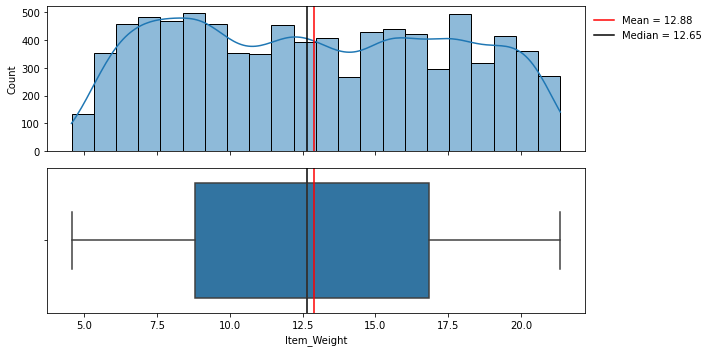

In [335]:
whaleyplot(df, 'Item_Weight')
plt.show()

- Item weights are fairly evenly distributed around the mean of 12.88.
- There are multiple peaks indicating underlying data clusters.

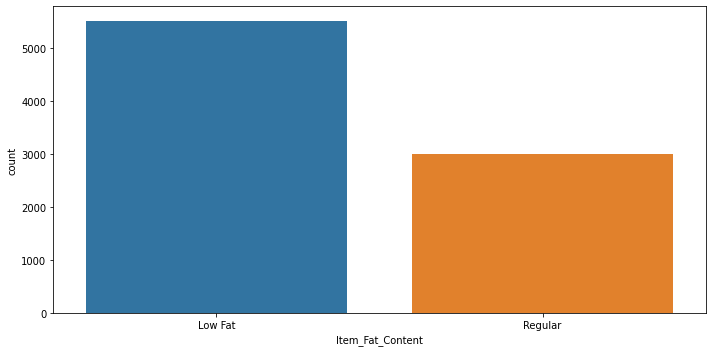

In [336]:
barplot(df, 'Item_Fat_Content')
plt.show()

* Most of the data is from 'Low Fat' items.

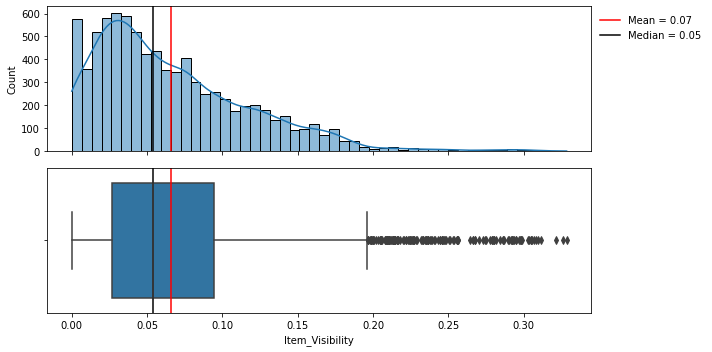

In [337]:
whaleyplot(df, 'Item_Visibility')
plt.show()

- The peak of the distribution occurs around the first quartile.
- TODO: There are a lot of 0 values.
- TODO: There are a number of outliers at the high end.

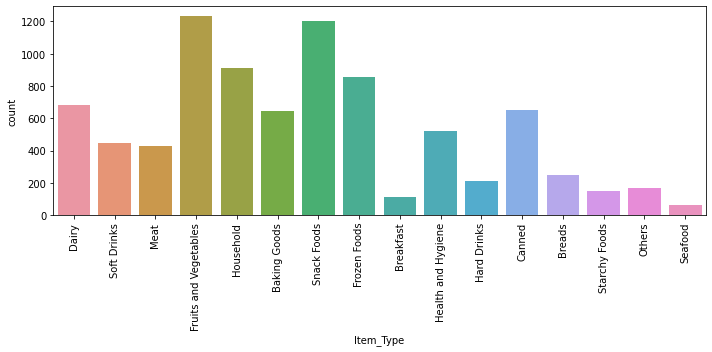

In [338]:
barplot(df, 'Item_Type', xtick_rotation=90)
plt.show()

- The top three item types are 'Fruits and Vegetables', 'Snack Foods', and 'Household'.

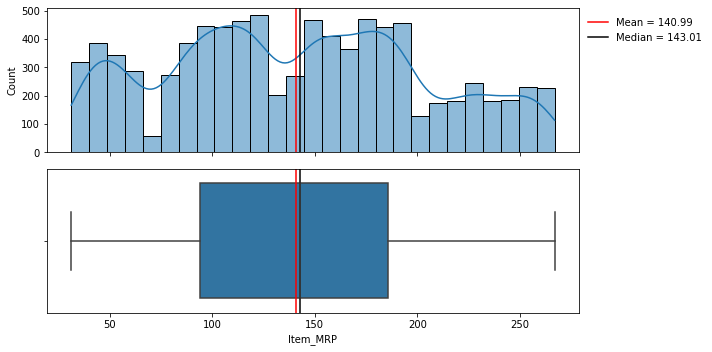

In [339]:
whaleyplot(df, 'Item_MRP')
plt.show()

- The items' prices are fairly evenly distributed around the mean of 140.99.
- There are multiple peaks indicating underlying data clusters.

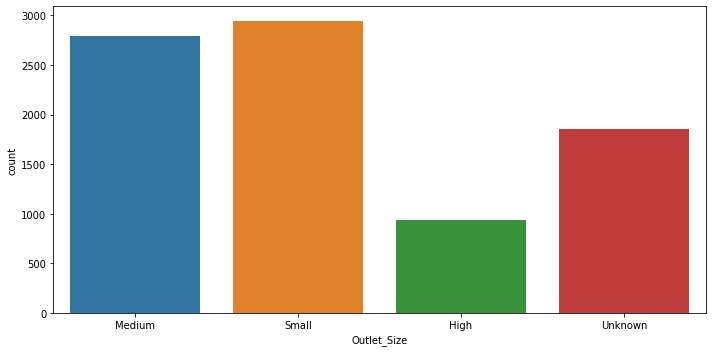

In [340]:
barplot(df, 'Outlet_Size')
plt.show()

- TODO: Is 'Unknown' supposed to be 'High'?

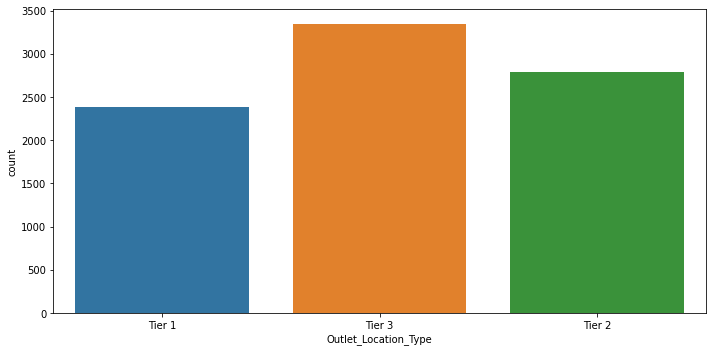

In [341]:
barplot(df, 'Outlet_Location_Type')
plt.show()

- A large part of the data comes from 'Tier 3' outlets.

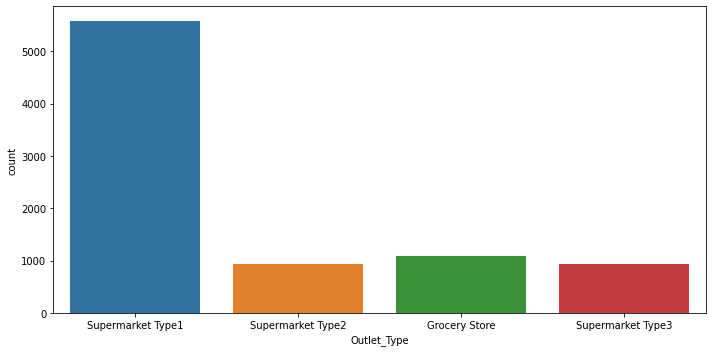

In [342]:
barplot(df, 'Outlet_Type')
plt.show()

- Most of the data comes from 'Supermarket Type1' outlets.

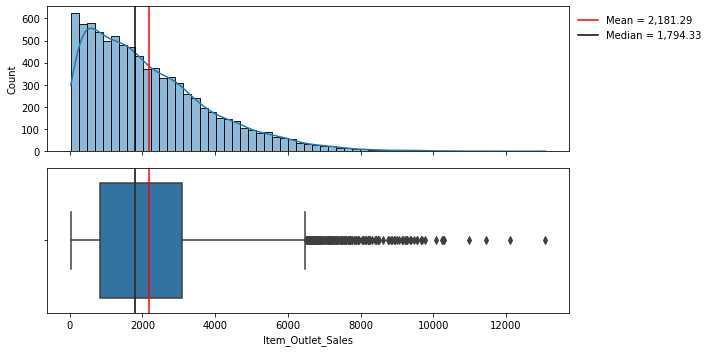

In [343]:
whaleyplot(df, 'Item_Outlet_Sales')
plt.show()

- Most of the item outlet sales are less than 2,000.
- TODO: There are a number of outliers at the high end.

#### Multivariate Analyses

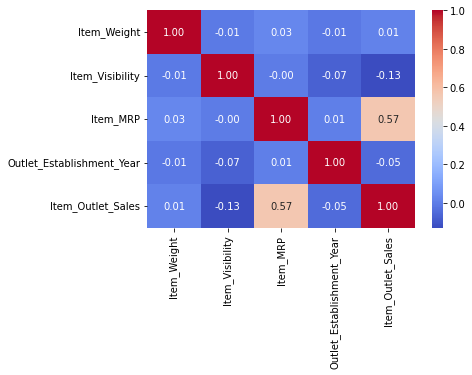

In [344]:
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.show()

- There is a moderate positive correlation between item price and item outlet sales.
- There are no other notable positive correlations.
- There are no notable negative correlations.

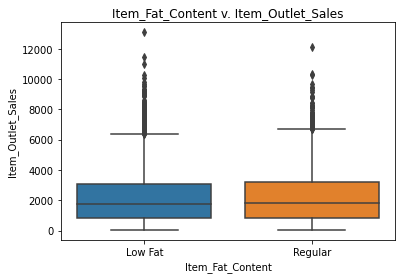

In [345]:
# Item_Fat_Content v. Item_Outlet_Sales
sns.boxplot(data=df, x='Item_Fat_Content', y='Item_Outlet_Sales')
plt.title('Item_Fat_Content v. Item_Outlet_Sales')
plt.show()

- 'Low Fat' and 'Regular' item outlet sales are about the same.

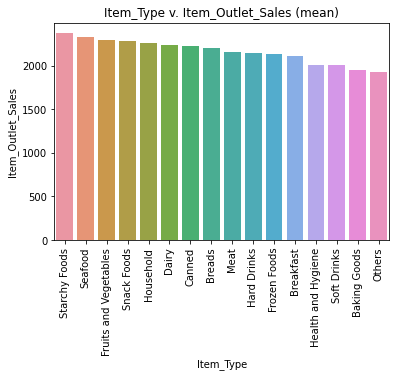

In [346]:
# Item_Type v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Item_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)
ax.set_title('Item_Type v. Item_Outlet_Sales (mean)')
ax.set_ylabel('Item_Outlet_Sales')
plt.xticks(rotation=90)
plt.show()

- The top three item types by mean sales are 'Starchy Foods', 'Seafood', and 'Fruits and Vegetables'.

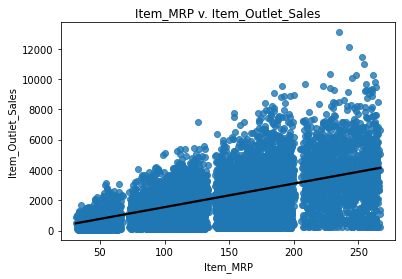

In [347]:
# Item_MRP v. Item_Outlet_Sales
ax = sns.regplot(data=df, 
                 x='Item_MRP', y='Item_Outlet_Sales', 
                 line_kws={'color': 'black', 'linestyle': '-'})
ax.set_title('Item_MRP v. Item_Outlet_Sales')
plt.show()

- There is a moderate positive correlation between item price and item outlet sales.

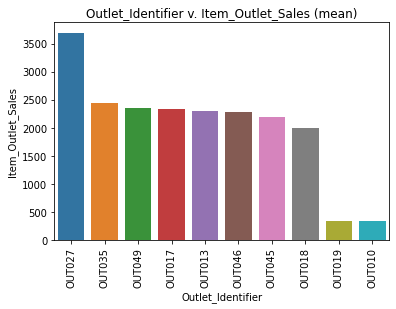

In [348]:
# Outlet_Identifier v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Outlet_Identifier')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)
ax.set_title('Outlet_Identifier v. Item_Outlet_Sales (mean)')
ax.set_ylabel('Item_Outlet_Sales')
plt.xticks(rotation=90)
plt.show()

- Outlet 'OUT027' has the highest mean item outlet sales.

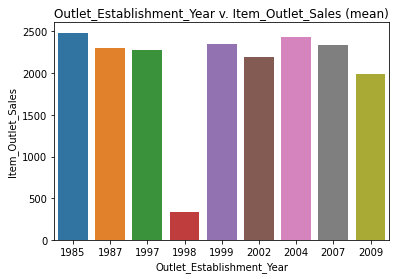

'OUT010' was established in 1998.


In [349]:
# Outlet_Establishment_Year v. Item_Outlet_Sales
sales_by_establishment_year = df.groupby('Outlet_Establishment_Year')['Item_Outlet_Sales'].mean()
ax = sns.barplot(x=sales_by_establishment_year.index, 
                 y=sales_by_establishment_year.values)
ax.set_title('Outlet_Establishment_Year v. Item_Outlet_Sales (mean)')
ax.set_ylabel('Item_Outlet_Sales')
plt.show()

# Which outlets were established in 1998?
filter = df['Outlet_Establishment_Year'] == 1998
outlet = df[filter]['Outlet_Identifier'].value_counts().index[0]
print(f'\'{outlet}\' was established in 1998.')

- The outlet established in 1998, 'OUT010', has the lowest mean item outlet sales.

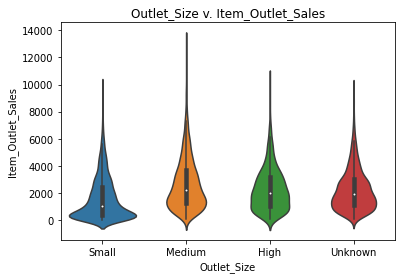

In [350]:
# Outlet_Size v. Item_Outlet_Sales
sns.violinplot(data=df, 
               x='Outlet_Size', y='Item_Outlet_Sales', 
               order=['Small','Medium','High','Unknown'])
plt.title('Outlet_Size v. Item_Outlet_Sales')
plt.show()

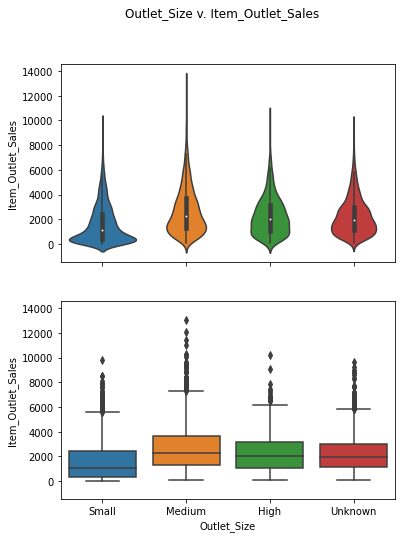

In [351]:
# Outlet_Size v. Item_Outlet_Sales
fig, (violinplot, boxplot) = plt.subplots(nrows=2, figsize=(6, 8), sharex=True, sharey=True)
sns.violinplot(data=df, 
               x='Outlet_Size', y='Item_Outlet_Sales',
               ax=violinplot,
               order=['Small','Medium','High','Unknown'])
violinplot.set_xlabel('')
sns.boxplot(data=df, 
            x='Outlet_Size', y='Item_Outlet_Sales',
            ax=boxplot,
            order=['Small','Medium','High','Unknown'])
#plt.title('Outlet_Size v. Item_Outlet_Sales')
fig.suptitle('Outlet_Size v. Item_Outlet_Sales')
plt.show()

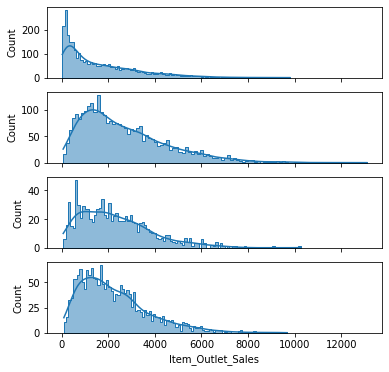

In [352]:
fig, axes = plt.subplots(figsize=(6, 6), nrows=4, sharex=True)

sns.histplot(data=df[df['Outlet_Size'] == 'Small'], x='Item_Outlet_Sales', ax=axes[0], bins=100, element='step', kde=True)
sns.histplot(data=df[df['Outlet_Size'] == 'Medium'], x='Item_Outlet_Sales', ax=axes[1], bins=100, element='step', kde=True)
sns.histplot(data=df[df['Outlet_Size'] == 'High'], x='Item_Outlet_Sales', ax=axes[2], bins=100, element='step', kde=True)
sns.histplot(data=df[df['Outlet_Size'] == 'Unknown'], x='Item_Outlet_Sales', ax=axes[3], bins=100, element='step', kde=True)

plt.show()

- 'Medium' outlets have the highest item outlet sales.
- 'Small' outlets have a larger number of lower item outlet sales.

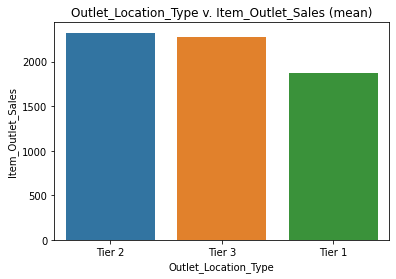

In [353]:
# Outlet_Location_Type v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Outlet_Location_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)
ax.set_title('Outlet_Location_Type v. Item_Outlet_Sales (mean)')
ax.set_ylabel('Item_Outlet_Sales')
plt.show()

- 'Tier 1' outlets have the lowest mean item outlet sales.

Outlet_Type
Supermarket Type3    3694.038558
Supermarket Type1    2316.181148
Supermarket Type2    1995.498739
Grocery Store         339.828500
Name: Item_Outlet_Sales, dtype: float64


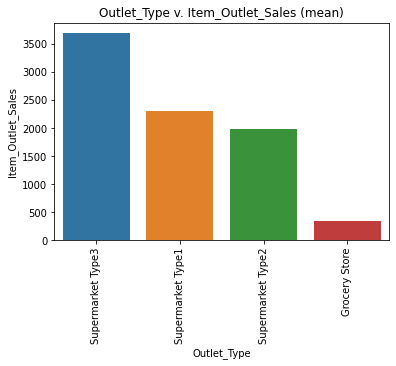

In [354]:
# Outlet_Type v. Item_Outlet_Sales (mean)
sales_by_outlet = df.groupby('Outlet_Type')['Item_Outlet_Sales'].mean().sort_values(ascending=False)
print(sales_by_outlet)
ax = sns.barplot(x=sales_by_outlet.index, y=sales_by_outlet.values)
ax.set_title('Outlet_Type v. Item_Outlet_Sales (mean)')
ax.set_ylabel('Item_Outlet_Sales')
plt.xticks(rotation=90)
plt.show()

- 'Supermarket Type3' outlets have the highest mean item outlet sales.
- 'Grocery Store' outlets have the lowest mean item outlet sales by over one order of magnitude.

## Part 4

**Part 4 Objective**: Perform explanatory data analyses on the dataset.

For Part 4, your task is to build several data visualizations to help your stakeholders better understand trends in the data.

- Build on your previous cleaning, exploration, and analysis.
- Create a minimum of two data visualizations that help others understand trends in the data (explanatory data analysis).
- Since these graphs are for reporting purposes, make sure they look nice by including titles, legends, etc.

### Explanatory Data Analyses

#### Does the item price and the outlet type impact item outlet sales?

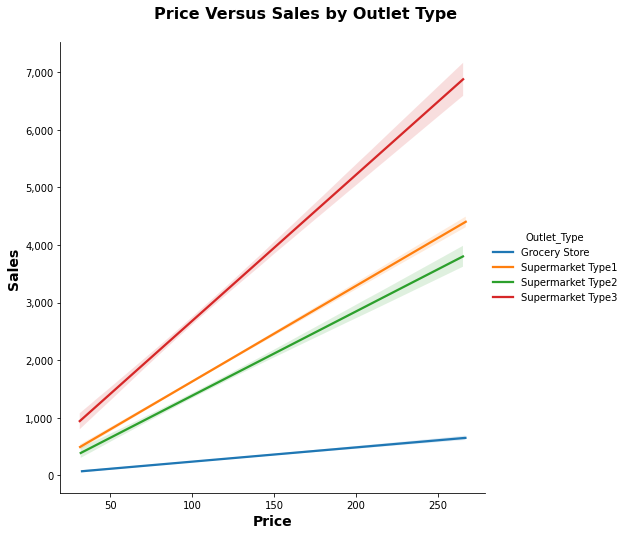

In [355]:
# Item_MRP v. Item_Outlet_Sales w. Outlet_Type
fg = sns.lmplot(data=df, 
                x='Item_MRP', y='Item_Outlet_Sales', 
                fit_reg=True, 
                height=7,
                hue='Outlet_Type', 
                hue_order=sorted(df['Outlet_Type'].unique()),
                scatter=False)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
fg.set_xlabels('Price', fontsize=14, fontweight='bold')
fg.set_ylabels('Sales', fontsize=14, fontweight='bold')
fg.fig.suptitle('Price Versus Sales by Outlet Type', 
                fontsize=16, fontweight='bold', y=1.05)
plt.show()

- Different outlets types have different correlations between item price and item outlet sales with 'Supermarket Type3' outlets having a higher positive correlation than the others in particular 'Grocery Store' outlets.

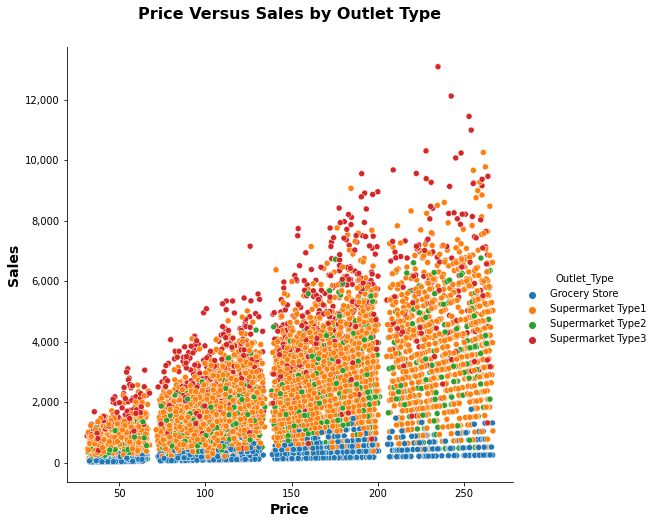

In [356]:
# Item_MRP v. Item_Outlet_Sales w. Outlet_Type
plt.figure(figsize=(8, 8))
ax = sns.scatterplot(x='Item_MRP', y='Item_Outlet_Sales', 
                     data=df, 
                     hue='Outlet_Type',
                     hue_order=sorted(df['Outlet_Type'].unique()))
plt.legend(title='Outlet_Type', bbox_to_anchor=(1, 0.5), frameon=False)
plt.gca().xaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
ax.set_xlabel('Price', fontsize=14, fontweight='bold')
ax.set_ylabel('Sales', fontsize=14, fontweight='bold')
ax.set_title('Price Versus Sales by Outlet Type', 
             fontsize=16, fontweight='bold', y=1.05)
sns.despine()
plt.show()

- In addition to varying between outlet types, the correlation between item price and item outlet sales is not linear: there are items with high prices that do not sell well and items with low prices that sell well.

- The retailer may want to adjust the prices of certain items to increase their sales or promote higher-priced items with a strong sales record. They could also investigate why certain items with high prices are not selling well.

#### Do different types of outlets carry different types of items?

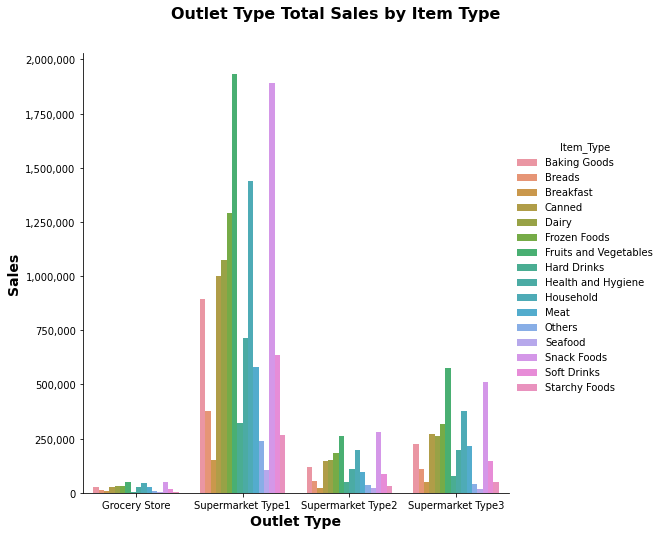

In [357]:
sales_by_outlet_type_item_type = df.groupby(['Outlet_Type', 'Item_Type'])['Item_Outlet_Sales'].sum().reset_index()
fg = sns.catplot(x='Outlet_Type', y='Item_Outlet_Sales', 
                 data=sales_by_outlet_type_item_type, 
                 height=7, 
                 hue='Item_Type', 
                 kind='bar')
plt.gca().yaxis.set_major_formatter(StrMethodFormatter('{x:,.0f}'))
fg.set_axis_labels('Outlet Type', 'Sales', font={'size': 14, 'weight': 'bold'})
fg.fig.suptitle('Outlet Type Total Sales by Item Type', 
                fontsize=16, fontweight='bold', y=1.05)
plt.show()

- The types of items sold varies across outlet types. In 'Supermarket Type1' outlets, the top-selling item types are 'Fruits and Vegetables', 'Snack Foods', and 'Household'. In 'Grocery Store' outlets, the top-selling item types are 'Snack Foods', 'Household', and 'Frozen Foods'.

- The retailer may want to stock more of the top-selling items in each outlet type or promote those items to increase sales.

- TODO: No support for recommendation as there is no correlation between item visibility and item outlet sales.

## Part 5

**Part 5 Objective**: The goal of this part is to help the retailer by using machine learning to make predictions about future sales based on the data provided.

For Part 5, you will go back to your original, uncleaned, sales prediction dataset with the goal of preventing data leakage.

You should load a fresh version of the original data set here using pd.read_csv() and start your cleaning process over to ensure there is no data leakage!

- Before splitting your data, you can drop duplicates and fix inconsistencies in categorical data. (There is a way to do this after the split, but for this project, you may perform this step before the split.)
- Identify the features (X) and target (y): Assign the "Item_Outlet_Sales" column as your target and the rest of the relevant variables as your features matrix.
- Perform a train test split
- Create a preprocessing object to prepare the dataset for Machine Learning
- Make sure your imputation of missing values occurs after the train test split using SimpleImputer.

### Future Sales Prediction using Machine Learning

#### Reload Data

In [358]:
df = pd.read_csv(dataset)